### label box의 w, h + anchor w, h plot
train + validation (split하기 전 train 전체 데이터)

12538
Columns: ['class', 'width', 'height']
   class     width    height
0      1  0.032813  0.095703
1      1  0.034375  0.097656
2      1  0.035938  0.101562
3      1  0.035938  0.105469
4      1  0.037500  0.107422


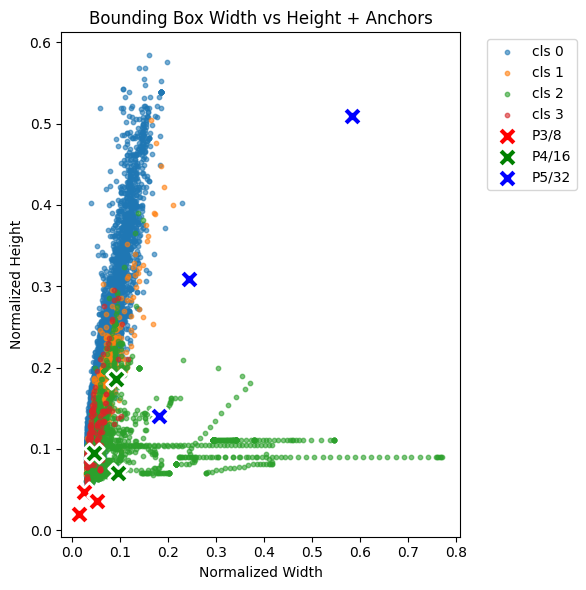


Class별 박스 개수:
  클래스 0: 10358개
  클래스 1: 1282개
  클래스 2: 1440개
  클래스 3: 232개


In [13]:
import glob
import pandas as pd
import matplotlib.pyplot as plt

# 1. 라벨 파일 경로
label_files = glob.glob('datasets/kaist-rgbt/train/labels/*.txt')

# 2. 데이터 수집
records = []
num_data = 0
for filepath in label_files:
    with open(filepath, 'r') as f:
        lines = f.read().strip().splitlines()
    for line in lines:
        parts = line.split()
        if len(parts) < 5:
            continue
        cls = int(parts[0])
        width = float(parts[3])
        height = float(parts[4])
        records.append({'class': cls, 'width': width, 'height': height})
    num_data += 1
    
print(num_data)

# 3. DataFrame 생성
df = pd.DataFrame(records)
print("Columns:", df.columns.tolist())
print(df.head())

# 4. 시각화: 클래스별 라벨 분포 + 앵커 오버레이
fig, ax = plt.subplots(figsize=(6,6))

# 4.1 클래스별 라벨 분포
for cls, group in df.groupby('class'):
    ax.scatter(group['width'], group['height'],
               label=f"cls {cls}", s=10, alpha=0.6)

# 4.2 앵커 정의 & 정규화
anchors_raw = [
    [10, 13, 16, 30, 33, 23],    # P3/8
    [30, 61, 62, 45, 59, 119],   # P4/16
    [116, 90, 156, 198, 373, 326] # P5/32
]
imgsz = 640
colors = ['red','green','blue']
layers = ['P3/8','P4/16','P5/32']

# 4.3 앵커 오버레이
for color, layer, pts in zip(colors, layers, anchors_raw):
    # (w,h) 쌍으로 뽑아 정규화
    ws = [pts[i]/imgsz     for i in range(0,len(pts),2)]
    hs = [pts[i+1]/imgsz   for i in range(0,len(pts),2)]
    ax.scatter(ws, hs,
               marker='X', s=200,
               c=color, edgecolor='white', linewidth=2,
               label=layer)

# 5. 마무리
ax.set_xlabel('Normalized Width')
ax.set_ylabel('Normalized Height')
ax.set_title('Bounding Box Width vs Height + Anchors')
ax.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

# 각 클래스별 박스 개수 출력
class_counts = df['class'].value_counts().sort_index()
print("\nClass별 박스 개수:")
for cls, cnt in class_counts.items():
    print(f"  클래스 {cls}: {cnt}개")

### label box의 w, h + anchor w, h plot
train + validation (split하기 전 train 전체 데이터)

Processed files: 12538
Total boxes: 13312


C:\Users\dlqud\AppData\Local\Temp\ipykernel_940\976175090.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  table = df.groupby(['h_bin','w_bin']).size().unstack(fill_value=0)


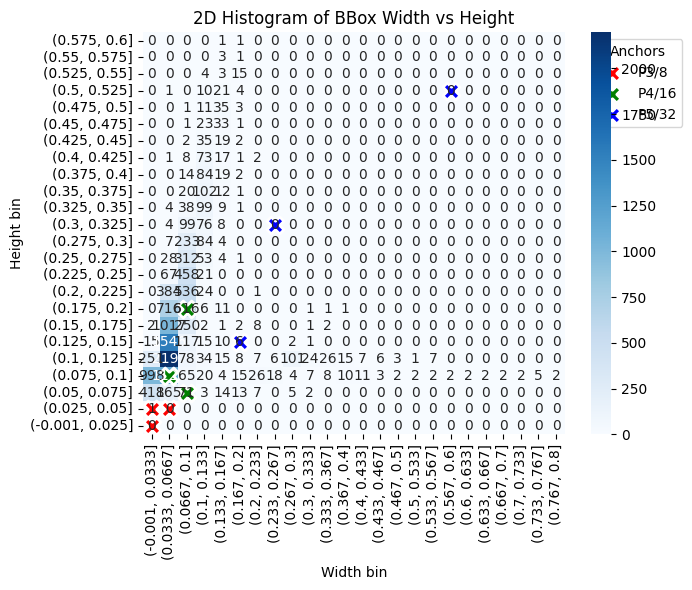

<Figure size 640x480 with 0 Axes>

In [59]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 라벨 파일 경로
label_files = glob.glob('datasets/kaist-rgbt/train/labels/*.txt')

# 2. 데이터 수집 (변경 없이 그대로)
records = []
num_data = 0
for filepath in label_files:
    with open(filepath, 'r') as f:
        lines = f.read().strip().splitlines()
    for line in lines:
        parts = line.split()
        if len(parts) < 5:
            continue
        # YOLO 포맷: cls, x, y, w, h
        w, h = float(parts[3]), float(parts[4])
        records.append((w, h))
    num_data += 1

print("Processed files:", num_data)
print("Total boxes:", len(records))

# 3. DataFrame 생성
df = pd.DataFrame(records, columns=['width','height'])

# --- 여기부터 히스토그램 테이블 생성 및 시각화 ---

# 4. bin edges 정의 (0~1 범위, 예: 10×10 그리드)

w_edges = np.linspace(0, 0.8, 25)
h_edges = np.linspace(0, 0.6, 25)

# 5. 각 박스를 bin index로 매핑
df['w_bin'] = pd.cut(df['width'], bins=w_edges, include_lowest=True)
df['h_bin'] = pd.cut(df['height'], bins=h_edges, include_lowest=True)

# 6. pivot table 형태로 count 집계
table = df.groupby(['h_bin','w_bin']).size().unstack(fill_value=0)

# 7. 히트맵 시각화
fig, ax = plt.subplots(figsize=(7,6))
sns.heatmap(table, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Width bin')
ax.set_ylabel('Height bin')
ax.set_title('2D Histogram of BBox Width vs Height')

# y축 뒤집기
ax.invert_yaxis()

# 4. 앵커 overlay
anchors = [
    [10,13, 16,30, 33,23],    # P3/8
    [30,61, 62,45, 59,119],   # P4/16
    [116,90,156,198,373,326]  # P5/32
]
imgsz = 640
colors = ['red','green','blue']
layers = ['P3/8','P4/16','P5/32']

for pts, c, layer in zip(anchors, colors, layers):
    # 하나만 레이블 붙이기 위해 flag
    first = True
    for i in range(0, len(pts), 2):
        w_norm, h_norm = pts[i]/imgsz, pts[i+1]/imgsz
        # bin index 계산 (0-based)
        w_idx = np.digitize(w_norm, w_edges) - 1
        h_idx = np.digitize(h_norm, h_edges) - 1
        # 셀 중앙에 마커
        ax.scatter(w_idx+0.5, h_idx+0.5,
                   marker='X', s=150, c=c,
                   edgecolor='white', linewidth=2,
                   label=layer if first else "")
        first = False

ax.legend(bbox_to_anchor=(1.05,1), loc='upper left', title="Anchors")
plt.tight_layout()
plt.show()


plt.tight_layout()
plt.show()


### anchor choice for P4

Processed files: 12538
Total boxes: 13312


C:\Users\dlqud\AppData\Local\Temp\ipykernel_27324\3846461536.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  table = df.groupby(['h_bin','w_bin']).size().unstack(fill_value=0)


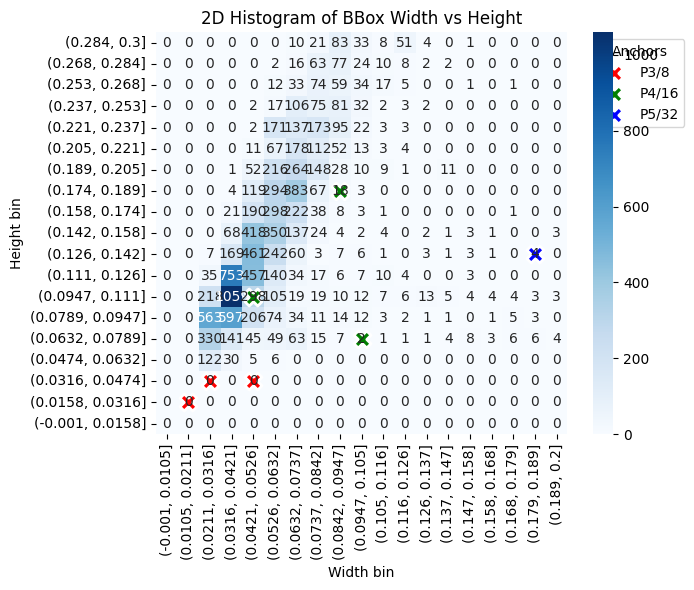

<Figure size 640x480 with 0 Axes>

In [4]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 라벨 파일 경로
label_files = glob.glob('datasets/kaist-rgbt/train/labels/*.txt')

# 2. 데이터 수집 (변경 없이 그대로)
records = []
num_data = 0
for filepath in label_files:
    with open(filepath, 'r') as f:
        lines = f.read().strip().splitlines()
    for line in lines:
        parts = line.split()
        if len(parts) < 5:
            continue
        # YOLO 포맷: cls, x, y, w, h
        w, h = float(parts[3]), float(parts[4])
        records.append((w, h))
    num_data += 1

print("Processed files:", num_data)
print("Total boxes:", len(records))

# 3. DataFrame 생성
df = pd.DataFrame(records, columns=['width','height'])

# --- 여기부터 히스토그램 테이블 생성 및 시각화 ---

# 4. bin edges 정의 (0~1 범위, 예: 10×10 그리드)

w_edges = np.linspace(0, 0.2, 20)
h_edges = np.linspace(0, 0.3, 20)

# 5. 각 박스를 bin index로 매핑
df['w_bin'] = pd.cut(df['width'], bins=w_edges, include_lowest=True)
df['h_bin'] = pd.cut(df['height'], bins=h_edges, include_lowest=True)

# 6. pivot table 형태로 count 집계
table = df.groupby(['h_bin','w_bin']).size().unstack(fill_value=0)

# 7. 히트맵 시각화
fig, ax = plt.subplots(figsize=(7,6))
sns.heatmap(table, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Width bin')
ax.set_ylabel('Height bin')
ax.set_title('2D Histogram of BBox Width vs Height')

# y축 뒤집기
ax.invert_yaxis()

# 4. 앵커 overlay
anchors = [
    [10,13, 16,30, 33,23],    # P3/8
    [30,61, 62,45, 59,119],   # P4/16
    [116,90,156,198,373,326]  # P5/32
]
imgsz = 640
colors = ['red','green','blue']
layers = ['P3/8','P4/16','P5/32']

for pts, c, layer in zip(anchors, colors, layers):
    # 하나만 레이블 붙이기 위해 flag
    first = True
    for i in range(0, len(pts), 2):
        w_norm, h_norm = pts[i]/imgsz, pts[i+1]/imgsz
        # bin index 계산 (0-based)
        w_idx = np.digitize(w_norm, w_edges) - 1
        h_idx = np.digitize(h_norm, h_edges) - 1
        # 셀 중앙에 마커
        ax.scatter(w_idx+0.5, h_idx+0.5,
                   marker='X', s=150, c=c,
                   edgecolor='white', linewidth=2,
                   label=layer if first else "")
        first = False

ax.legend(bbox_to_anchor=(1.05,1), loc='upper left', title="Anchors")
plt.tight_layout()
plt.show()


plt.tight_layout()
plt.show()


### anchor choice for P3

Processed files: 12538
Total boxes: 13312


C:\Users\dlqud\AppData\Local\Temp\ipykernel_27324\1045216493.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  table = df.groupby(['h_bin','w_bin']).size().unstack(fill_value=0)


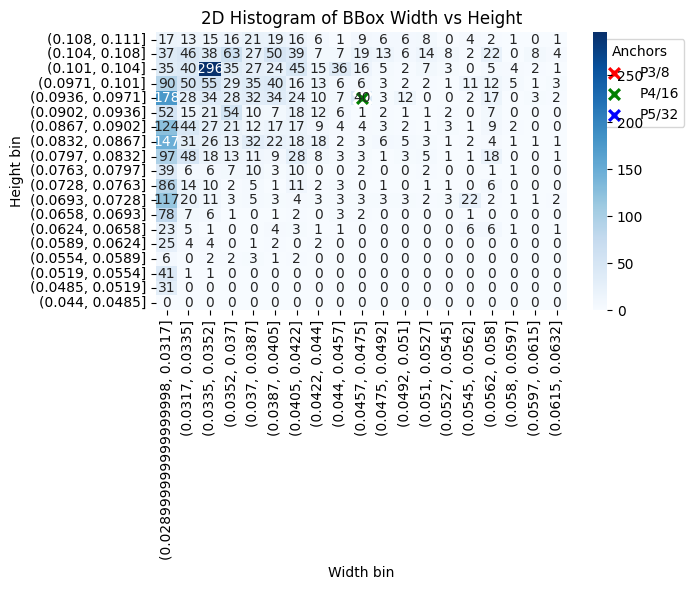

<Figure size 640x480 with 0 Axes>

In [10]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 라벨 파일 경로
label_files = glob.glob('datasets/kaist-rgbt/train/labels/*.txt')

# 2. 데이터 수집 (변경 없이 그대로)
records = []
num_data = 0
for filepath in label_files:
    with open(filepath, 'r') as f:
        lines = f.read().strip().splitlines()
    for line in lines:
        parts = line.split()
        if len(parts) < 5:
            continue
        # YOLO 포맷: cls, x, y, w, h
        w, h = float(parts[3]), float(parts[4])
        records.append((w, h))
    num_data += 1

print("Processed files:", num_data)
print("Total boxes:", len(records))

# 3. DataFrame 생성
df = pd.DataFrame(records, columns=['width','height'])

# --- 여기부터 히스토그램 테이블 생성 및 시각화 ---

# 4. bin edges 정의 (0~1 범위, 예: 10×10 그리드)

w_edges = np.linspace(0.03, 0.0632, 20)
h_edges = np.linspace(0.045, 0.111, 20)

# 5. 각 박스를 bin index로 매핑
df['w_bin'] = pd.cut(df['width'], bins=w_edges, include_lowest=True)
df['h_bin'] = pd.cut(df['height'], bins=h_edges, include_lowest=True)

# 6. pivot table 형태로 count 집계
table = df.groupby(['h_bin','w_bin']).size().unstack(fill_value=0)

# 7. 히트맵 시각화
fig, ax = plt.subplots(figsize=(7,6))
sns.heatmap(table, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Width bin')
ax.set_ylabel('Height bin')
ax.set_title('2D Histogram of BBox Width vs Height')

# y축 뒤집기
ax.invert_yaxis()

# 4. 앵커 overlay
anchors = [
    [10,13, 16,30, 33,23],    # P3/8
    [30,61, 62,45, 59,119],   # P4/16
    [116,90,156,198,373,326]  # P5/32
]
imgsz = 640
colors = ['red','green','blue']
layers = ['P3/8','P4/16','P5/32']

for pts, c, layer in zip(anchors, colors, layers):
    # 하나만 레이블 붙이기 위해 flag
    first = True
    for i in range(0, len(pts), 2):
        w_norm, h_norm = pts[i]/imgsz, pts[i+1]/imgsz
        # bin index 계산 (0-based)
        w_idx = np.digitize(w_norm, w_edges) - 1
        h_idx = np.digitize(h_norm, h_edges) - 1
        # 셀 중앙에 마커
        ax.scatter(w_idx+0.5, h_idx+0.5,
                   marker='X', s=150, c=c,
                   edgecolor='white', linewidth=2,
                   label=layer if first else "")
        first = False

ax.legend(bbox_to_anchor=(1.05,1), loc='upper left', title="Anchors")
plt.tight_layout()
plt.show()


plt.tight_layout()
plt.show()


### process anchor

In [11]:
# Step 1: Define the anchors from images (in normalized format)
# Image size is 640, so to convert to pixel coordinates, multiply by 640 and round

import numpy as np

# P5
p5 = [
    (0.233/2, 0.675/2),
    (0.15, 0.975/2),
    (0.567/2, 0.225/2),
]

# P4
p4 = [
    ((0.0632 + 0.0737)/2, 0.189),
    (0.0526, 0.142),
    (0.0421, (0.111 + 0.126)/2),
]

# P3
p3 = [
    (0.031, (0.0867 + 0.0902)/2),
    (0.031, (0.0693 + 0.0728)/2),
    (0.0343, (0.0101 + 0.104)/2),
]

# Function to convert to pixel values (width, height), rounded to integer
def to_pixel_coords(pairs, img_size=640):
    return [tuple(round(x * img_size) for x in pair) for pair in pairs]

anchors_p5 = to_pixel_coords(p5)
anchors_p4 = to_pixel_coords(p4)
anchors_p3 = to_pixel_coords(p3)

anchors = [anchors_p3, anchors_p4, anchors_p5]
anchors


[[(20, 57), (20, 45), (22, 37)],
 [(44, 121), (34, 91), (27, 76)],
 [(75, 216), (96, 312), (181, 72)]]

12538
Columns: ['class', 'width', 'height']
   class     width    height
0      1  0.032813  0.095703
1      1  0.034375  0.097656
2      1  0.035938  0.101562
3      1  0.035938  0.105469
4      1  0.037500  0.107422


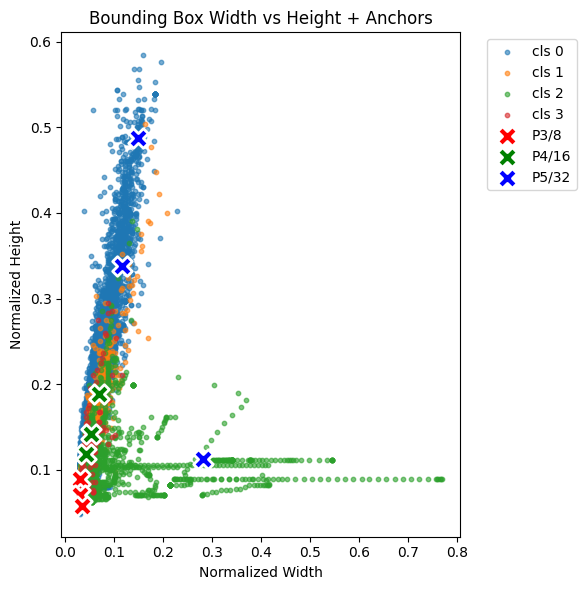

In [12]:
import glob
import pandas as pd
import matplotlib.pyplot as plt

# 1. 라벨 파일 경로
label_files = glob.glob('datasets/kaist-rgbt/train/labels/*.txt')

# 2. 데이터 수집
records = []
num_data = 0
for filepath in label_files:
    with open(filepath, 'r') as f:
        lines = f.read().strip().splitlines()
    for line in lines:
        parts = line.split()
        if len(parts) < 5:
            continue
        cls = int(parts[0])
        width = float(parts[3])
        height = float(parts[4])
        records.append({'class': cls, 'width': width, 'height': height})
    num_data += 1
    
print(num_data)

# 3. DataFrame 생성
df = pd.DataFrame(records)
print("Columns:", df.columns.tolist())
print(df.head())

# 4. 시각화: 클래스별 라벨 분포 + 앵커 오버레이
fig, ax = plt.subplots(figsize=(6,6))

# 4.1 클래스별 라벨 분포
for cls, group in df.groupby('class'):
    ax.scatter(group['width'], group['height'],
               label=f"cls {cls}", s=10, alpha=0.6)

# 4.2 앵커 정의 & 정규화
anchors_raw = [
    # P3 (stride 8)
    [20, 57, 20, 45, 22, 37],

    # P4 (stride 16)
    [44, 121, 34, 91, 27, 76],

    # P5 (stride 32)
    [75, 216, 96, 312, 181, 72]
]
imgsz = 640
colors = ['red','green','blue']
layers = ['P3/8','P4/16','P5/32']

# 4.3 앵커 오버레이
for color, layer, pts in zip(colors, layers, anchors_raw):
    # (w,h) 쌍으로 뽑아 정규화
    ws = [pts[i]/imgsz     for i in range(0,len(pts),2)]
    hs = [pts[i+1]/imgsz   for i in range(0,len(pts),2)]
    ax.scatter(ws, hs,
               marker='X', s=200,
               c=color, edgecolor='white', linewidth=2,
               label=layer)

# 5. 마무리
ax.set_xlabel('Normalized Width')
ax.set_ylabel('Normalized Height')
ax.set_title('Bounding Box Width vs Height + Anchors')
ax.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()
